In [66]:
import vk
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import os

import markov_clustering as mc
from matplotlib import pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [29]:
access_token = '32c3001600afaf6dee95e3a6cbbc2a862850dacf033075e44a7c923f8258041ff9e8393c29ca160b7cc37'
expires_in = 86400
user_id = 195882232
#user_id = 95266426
id_app = 6429112

session = vk.Session(access_token=access_token)

vk_api = vk.API(session, v='5.73')

In [30]:
my_info = vk_api.users.get(user_ids=user_id,
                           fields = {'bdate'})

my_info

[{'bdate': '30.5.1997',
  'first_name': 'Никита',
  'id': 195882232,
  'last_name': 'Мокров'}]

In [36]:
def make_info(info):
    nan = np.nan
    size = len(info)
    data = {
        'user_id' : list(map(lambda i: int(info[i]['id'] if 'id' in info[i] else nan), range(size))), 
        'sex_id' : list(map(lambda i: int(info[i]['sex'] if 'sex' in info[i] else nan), range(size))),
        'first_name' : list(map(lambda i: info[i]['first_name'] if 'first_name' in info[i] else nan, range(size))),
        'last_name' : list(map(lambda i: info[i]['last_name'] if 'last_name' in info[i] else nan, range(size))),
        'city_id' : list(map(lambda i: int(info[i]['city']['id']) if 'city' in info[i] and 'id' in info[i]['city'] else nan, range(size))),
        'city_name' : list(map(lambda i: info[i]['city']['title'] if 'city' in info[i] and 'title' in info[i]['city'] else nan, range(size))),
        'home_name' : list(map(lambda i: info[i]['home_town'] if 'home_town' in info[i] else nan, range(size))),
        'univer_id' : list(map(lambda i: int(info[i]['universities'][0]['id']) if 'universities' in info[i] and len(info[i]['universities'])>1 else nan, range(size))),
        'univer_name' : list(map(lambda i: info[i]['universities'][0]['name'] if 'universities' in info[i] and len(info[i]['universities'])>1 else nan, range(size))),
        'school_id' : list(map(lambda i: int(info[i]['schools'][0]['id']) if 'schools' in info[i] and len(info[i]['schools'])>1 else nan, range(size))),
        'school_name' : list(map(lambda i: info[i]['schools'][0]['name'] if 'schools' in info[i] and len(info[i]['schools'])>1 else nan, range(size))),
        'occupt_id' : list(map(lambda i: int(info[i]['occupation']['id']) if 'occupation' in info[i] and 'id' in info[i]['occupation'] else nan, range(size))),
        'occupt_name' : list(map(lambda i: info[i]['occupation']['name'] if 'occupation' in info[i] and 'name' in info[i]['occupation'] else nan, range(size))),
        'occupt_type' : list(map(lambda i: info[i]['occupation']['type'] if 'occupation' in info[i] and 'type' in info[i]['occupation'] else nan, range(size))),
        'bd_year_id' : list(map(lambda i: int(info[i]['bdate'].split(r'.')[2]) if 'bdate' in info[i] and len(info[i]['bdate'].split(r'.'))>2 else nan, range(size))),
        'bd_mont_id' : list(map(lambda i: int(info[i]['bdate'].split(r'.')[1]) if 'bdate' in info[i] else nan, range(size))),
        'bd_day_id' : list(map(lambda i: int(info[i]['bdate'].split(r'.')[0]) if 'bdate' in info[i] else nan, range(size)))
    }
    
    df_info = pd.DataFrame(data=data)
    return df_info
    
def make_comm(user_id, friends_list):
    
    if 'fr_{}.csv'.format(user_id) in os.listdir("fr_user_id"):
        df_comm = pd.read_csv('fr_user_id/fr_{}.csv'.format(user_id))
        df_comm.set_index('users_id', inplace=True)
    else:
        df_comm = pd.DataFrame(columns=friends_list)
        df_comm['users_id'] = friends_list
        df_comm.set_index('users_id', inplace=True)
        for idx in tqdm(friends_list):
            time.sleep(1)
            try: 
                frx = vk_api.friends.get(user_id=idx)['items']
                col = np.unique(list(map(lambda fr: fr if fr in friends_list else 0, frx)))
                col = np.delete(col, 0)
                df_comm.loc[idx][col] = np.ones_like(df_comm.loc[idx][col])
            except:
                print('User {} was deleted'.format(idx))

        df_comm.replace(np.nan, 0, inplace=True)
        df_comm.to_csv('fr_user_id/fr_{}.csv'.format(user_id))
    return df_comm
    
def build_friends(user_id):
    friends_list = vk_api.friends.get(user_id=user_id)['items']
    
    info = vk_api.users.get(user_ids=[user_id] + friends_list,
                            fields = {'city', 'bdate',
                                  'home_town',
                                  'occupation',
                                  'schools', 'sex',
                                  'universities'})
    
    df_info = make_info(info)
    df_comm = make_comm(user_id, friends_list)
    
    return df_info, df_comm, friends_list

In [38]:
df_info, df_comm, friends_list = build_friends(user_id)

In [46]:
df_info.head()

,bd_day_id,bd_mont_id,bd_year_id,city_id,city_name,first_name,home_name,last_name,occupt_id,occupt_name,occupt_type,school_id,school_name,sex_id,univer_id,univer_name,user_id
0,30.0,5.0,1997.0,857.0,Долгопрудный,Никита,Иваново,Мокров,297.0,МФТИ (ГУ),university,NaN,NaN,2,297.0,МФТИ (ГУ),195882232
1,26.0,12.0,1987.0,1.0,Москва,Илья,,Глухов,297.0,МФТИ (ГУ),university,NaN,NaN,2,NaN,NaN,362289
2,14.0,1.0,1989.0,1.0,Москва,Алексей,Харьков,Зайцев,34737049.0,Сколковский институт науки и технологий,work,209447.0,Лицей №27,2,297.0,МФТИ (ГУ),1146964
3,24.0,12.0,1988.0,1.0,Москва,Максим,Череповец,Панов,297.0,МФТИ (ГУ),university,170099.0,Школа №33 им. Карла Маркса,2,NaN,NaN,1486122
4,9.0,6.0,1995.0,857.0,Долгопрудный,Елизавета,Санкт-Петербург,Сайгина,297.0,МФТИ (ГУ),university,462.0,Лицей №597,1,NaN,NaN,1988333


In [40]:
A = df_comm.as_matrix()
A.shape

(569, 569)

In [41]:
#Delete removed users
ind = np.arange(A.shape[0])[A.sum(axis=0) == 0]
A = np.delete(A, ind, 0)
A = np.delete(A, ind, 1)
A.shape

(566, 566)

In [42]:
result = mc.run_mcl(A)
clusters = mc.get_clusters(result)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


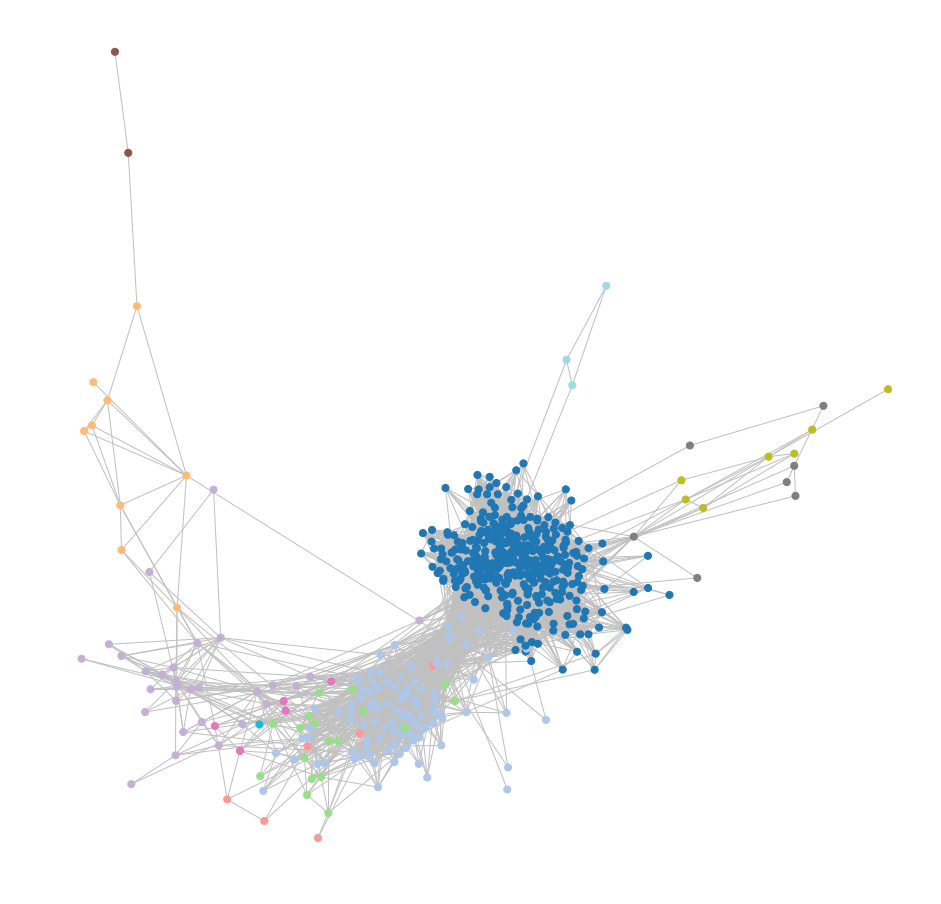

In [43]:
fig = plt.figure(figsize=(16, 16))
mc.draw_graph(A, clusters, node_size=50, with_labels=False, edge_color="silver", figsize=(16, 16))
fig.savefig('graph_{}.png'.format(user_id), dpi=300)

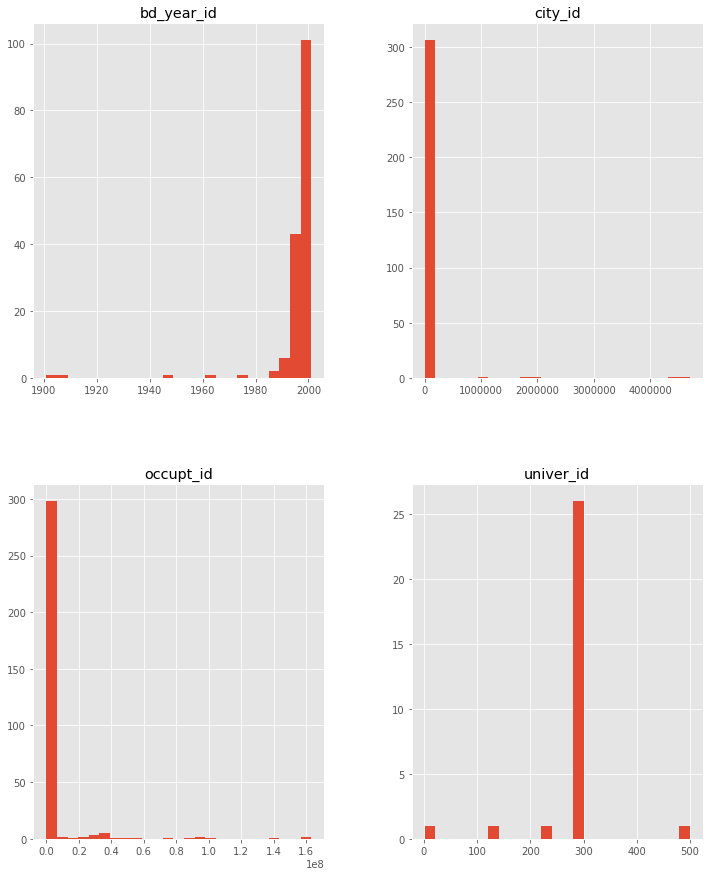

In [77]:
col = ['bd_year_id', 'city_id', 'occupt_id', 'univer_id']
df_info.set_index('user_id').loc[np.array(friends_list)[np.array(clusters[0])]][col].hist(figsize=(12,15), bins=25)
plt.show()

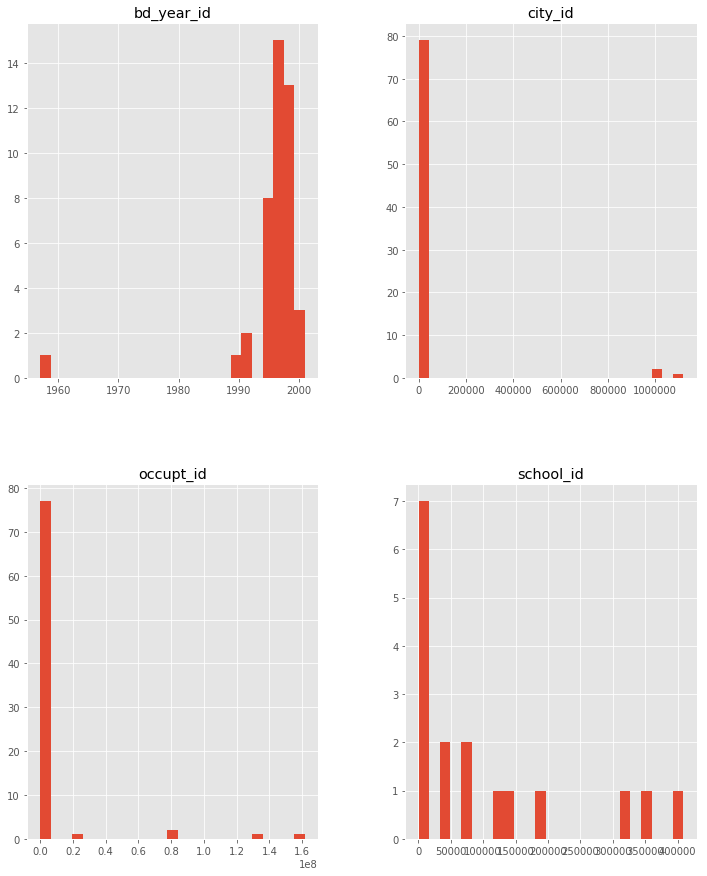

In [81]:
col = ['bd_year_id', 'city_id', 'occupt_id', 'school_id']
df_info.set_index('user_id').loc[np.array(friends_list)[np.array(clusters[1])]][col].hist(figsize=(12,15), bins=25)
plt.show()

In [83]:
df_info.set_index('user_id').loc[np.array(friends_list)[np.array(clusters[2])]]

,bd_day_id,bd_mont_id,bd_year_id,city_id,city_name,first_name,home_name,last_name,occupt_id,occupt_name,occupt_type,school_id,school_name,sex_id,univer_id,univer_name
user_id,,,,,,,,,,,,,,,,
6321808,6.0,8.0,1991.0,55.0,Иваново,Виталий,Иваново,Захаров,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
12150128,24.0,5.0,1990.0,55.0,Иваново,Дарья,Иваново,Ширяева,499.0,ИГЭУ им. Ленина,university,NaN,NaN,1,NaN,NaN
15446963,16.0,6.0,NaN,1.0,Москва,Ирина,Григориополь,Пушкаренко,499.0,ИГЭУ им. Ленина,university,34963.0,Школа №2 им. А. Стоева (A. Stoev),1,499.0,ИГЭУ им. Ленина\r\n
22914105,20.0,2.0,NaN,NaN,NaN,Ксеня,,Корсар,499.0,ИГЭУ им. Ленина,university,NaN,NaN,1,NaN,NaN
25398914,6.0,1.0,NaN,55.0,Иваново,Ксения,Иваново,Стаброва,55319105.0,"АКБ ""Акция"" ОАО",work,NaN,NaN,1,498.0,ИГХТУ\r\n
31328203,NaN,NaN,NaN,376.0,Полярные Зори,Наталья,Мурманск,Шишкова,NaN,"Филиал АО ""Концерн Росэнергоатом"" ""Кольская АЭС""",work,NaN,NaN,1,NaN,NaN
32318458,28.0,10.0,1989.0,55.0,Иваново,Алексей,Иваново,Стабров,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
84929566,16.0,11.0,1995.0,1.0,Москва,Rudolf,Москва,Schenker,128.0,НИУ ВШЭ (ГУ-ВШЭ),university,4474.0,Лицей №1535,1,128.0,НИУ ВШЭ (ГУ-ВШЭ)
282681792,5.0,1.0,1998.0,857.0,Долгопрудный,Даня,Чебоксары,Прохоров,297.0,МФТИ (ГУ),university,NaN,NaN,2,NaN,NaN


In [85]:
df_info.set_index('user_id').loc[np.array(friends_list)[np.array(clusters[3])]]

,bd_day_id,bd_mont_id,bd_year_id,city_id,city_name,first_name,home_name,last_name,occupt_id,occupt_name,occupt_type,school_id,school_name,sex_id,univer_id,univer_name
user_id,,,,,,,,,,,,,,,,
7291204,19.0,10.0,NaN,1.0,Москва,Елизавета,Иваново,Грушанская,11571.0,РЭШ,university,NaN,NaN,1,NaN,NaN
8012862,NaN,NaN,NaN,55.0,Иваново,Сергей,Рязань,Витязев,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
12587306,18.0,4.0,1994.0,NaN,NaN,Олег,,Павлов,128.0,НИУ ВШЭ (ГУ-ВШЭ),university,NaN,NaN,2,128.0,НИУ ВШЭ (ГУ-ВШЭ)
16027619,28.0,1.0,1994.0,55.0,Иваново,Сергей,Иваново,Синицын,499.0,ИГЭУ им. Ленина,university,NaN,NaN,2,NaN,NaN
30038508,13.0,12.0,1993.0,1029502.0,Иваново,Илья,Иваново,Баусов,499.0,ИГЭУ им. Ленина,university,NaN,NaN,2,NaN,NaN
53887826,13.0,1.0,NaN,55.0,Иваново,Настя,NaN,Мокрова,774.0,СГИК (бывш. СГАКИ),university,NaN,NaN,1,NaN,NaN
54083329,24.0,4.0,NaN,55.0,Иваново,Анна,NaN,Гукасян,499.0,ИГЭУ им. Ленина,university,NaN,NaN,1,NaN,NaN
67897492,NaN,NaN,NaN,55.0,Иваново,Егор,Иваново,Пылаев,497.0,ИвГУ,university,NaN,NaN,2,NaN,NaN
70579285,3.0,2.0,NaN,55.0,Иваново,Александр,Иваново,Тимофеев,499.0,ИГЭУ им. Ленина,university,NaN,NaN,2,499.0,ИГЭУ им. Ленина


In [54]:
df_info.set_index('user_id').loc[np.array(friends_list)[np.array(clusters[4])]]

,bd_day_id,bd_mont_id,bd_year_id,city_id,city_name,first_name,home_name,last_name,occupt_id,occupt_name,occupt_type,school_id,school_name,sex_id,univer_id,univer_name
user_id,,,,,,,,,,,,,,,,
7488953,NaN,NaN,NaN,55.0,Иваново,Алексей,NaN,Евгеньевич,NaN,ИвГУ,work,NaN,NaN,2,NaN,NaN
8240681,6.0,1.0,NaN,1.0,Москва,Игорь,NaN,Кожелин,161664433.0,Физтех.Старт,work,NaN,NaN,2,NaN,NaN
85347169,24.0,2.0,NaN,1.0,Москва,Женя,NaN,Коновалов,250.0,МГТУ им. Н. Э. Баумана,university,NaN,NaN,2,NaN,NaN
125468335,2.0,11.0,1998.0,109.0,Пенза,Andrey,Пенза,Pokrovskiy,297.0,МФТИ (ГУ),university,NaN,NaN,2,NaN,NaN
152810514,9.0,1.0,1998.0,857.0,Долгопрудный,Валерия,Нижний Тагил,Филиппова,297.0,МФТИ (ГУ),university,NaN,NaN,1,NaN,NaN
196709229,17.0,3.0,NaN,1.0,Москва,Илья,Иваново,Аксаковский,2.0,МГУ,university,NaN,NaN,2,NaN,NaN


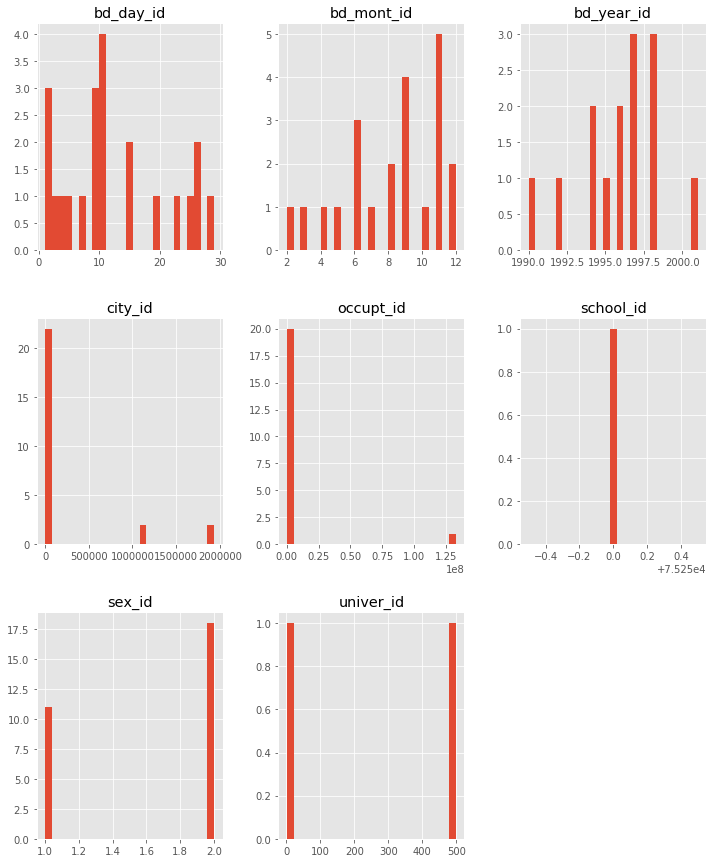

In [88]:
df_info.set_index('user_id').loc[np.array(friends_list)[np.array(clusters[5])]].hist(figsize=(12,15), bins=25)
plt.show()

In [90]:
df_info.set_index('user_id').loc[np.array(friends_list)[np.array(clusters[6])]]

,bd_day_id,bd_mont_id,bd_year_id,city_id,city_name,first_name,home_name,last_name,occupt_id,occupt_name,occupt_type,school_id,school_name,sex_id,univer_id,univer_name
user_id,,,,,,,,,,,,,,,,
30660318,18.0,9.0,1993.0,1.0,Москва,Андрей,Москва,Барановский,328.0,РГГУ,university,10716.0,Школа №1323,2,NaN,NaN
361409968,NaN,NaN,NaN,NaN,NaN,Dasha,,Berezhnaya,297.0,МФТИ (ГУ),university,NaN,NaN,1,NaN,NaN


In [57]:
df_info.set_index('user_id').loc[np.array(friends_list)[np.array(clusters[7])]]

,bd_day_id,bd_mont_id,bd_year_id,city_id,city_name,first_name,home_name,last_name,occupt_id,occupt_name,occupt_type,school_id,school_name,sex_id,univer_id,univer_name
user_id,,,,,,,,,,,,,,,,
60931317,NaN,NaN,NaN,1119489.0,Иваново,Эвелина,Иваново,Новикова,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
66579007,20.0,4.0,1998.0,55.0,Иваново,Максим,,Яшков,496.0,"АСИ ИВГПУ (бывш. ИГАСУ, ИИСИ)",university,NaN,NaN,2,NaN,NaN
83618069,23.0,9.0,NaN,55.0,Иваново,Илья,Иваново/Муром,Богатов,497.0,ИвГУ,university,NaN,NaN,2,NaN,NaN
135852095,5.0,1.0,2000.0,55.0,Иваново,Александр,NaN,Войкин,2.0,МГУ,university,NaN,NaN,2,NaN,NaN
242512605,NaN,NaN,NaN,NaN,NaN,Daria,NaN,Benedict,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN


In [58]:
df_info.set_index('user_id').loc[np.array(friends_list)[np.array(clusters[8])]]

,bd_day_id,bd_mont_id,bd_year_id,city_id,city_name,first_name,home_name,last_name,occupt_id,occupt_name,occupt_type,school_id,school_name,sex_id,univer_id,univer_name
user_id,,,,,,,,,,,,,,,,
73396145,14.0,3.0,NaN,857.0,Долгопрудный,Дмитрий,,Кондратьев,83012.0,Школа №9,school,NaN,NaN,2,NaN,NaN
146288050,15.0,12.0,NaN,857.0,Долгопрудный,Nusrik,Ташкент,Nosirov,297.0,МФТИ (ГУ),university,NaN,NaN,2,NaN,NaN
166611827,2.0,1.0,NaN,122.0,Рязань,Ирина,Рязань,Скобина,297.0,МФТИ (ГУ),university,48659.0,Специализированный учебно-научный центр МГУ (С...,1,NaN,NaN
166796399,5.0,7.0,2000.0,1.0,Москва,Александра,,Новикова,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
185995530,NaN,NaN,NaN,55.0,Иваново,Ирина,,Жадан,497.0,ИвГУ,university,NaN,NaN,1,NaN,NaN
237784459,23.0,5.0,1997.0,857.0,Долгопрудный,Максим,,Дробин,55111.0,МФТИ (ГУ) (см. в Москве),university,NaN,NaN,2,NaN,NaN
298872242,NaN,NaN,NaN,61.0,Калининград,Павел,,Малинин,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN


In [59]:
df_info.set_index('user_id').loc[np.array(friends_list)[np.array(clusters[9])]]

,bd_day_id,bd_mont_id,bd_year_id,city_id,city_name,first_name,home_name,last_name,occupt_id,occupt_name,occupt_type,school_id,school_name,sex_id,univer_id,univer_name
user_id,,,,,,,,,,,,,,,,
144782717,14.0,4.0,1998.0,1.0,Москва,Степан,Самара,Солоднев,NaN,Физтех-Центр,work,NaN,NaN,2,NaN,NaN
145254690,31.0,1.0,NaN,NaN,NaN,Валя,Москва,Кретова,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
188307628,19.0,3.0,1996.0,NaN,NaN,Толя,Өфө,Гришин,297.0,МФТИ (ГУ),university,3316.0,Гимназия №93,2,NaN,NaN
204380543,NaN,NaN,NaN,55.0,Иваново,Александр,,Балуев,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
236114377,NaN,NaN,NaN,1.0,Москва,Егор,,Кельмяшкин,297.0,МФТИ (ГУ),university,NaN,NaN,2,NaN,NaN
246633627,14.0,11.0,1997.0,1.0,Москва,Ксения,Иваново,Лопухина,109196188.0,Ассоциация Победителей Олимпиад (АПО),work,NaN,NaN,1,NaN,NaN
291090648,21.0,9.0,NaN,NaN,NaN,Егор,Иваново,Абрамов,499.0,ИГЭУ им. Ленина,university,NaN,NaN,2,NaN,NaN


In [60]:
df_info.set_index('user_id').loc[np.array(friends_list)[np.array(clusters[10])]]

,bd_day_id,bd_mont_id,bd_year_id,city_id,city_name,first_name,home_name,last_name,occupt_id,occupt_name,occupt_type,school_id,school_name,sex_id,univer_id,univer_name
user_id,,,,,,,,,,,,,,,,
149101256,7.0,1.0,1997.0,NaN,NaN,Елена,Смоленск,Черненкова,297.0,МФТИ (ГУ),university,129068.0,Педагогический лицей им. Кирилла и Мефодия (ПЛИ),1,NaN,NaN


In [61]:
df_info.set_index('user_id').loc[np.array(friends_list)[np.array(clusters[11])]]

,bd_day_id,bd_mont_id,bd_year_id,city_id,city_name,first_name,home_name,last_name,occupt_id,occupt_name,occupt_type,school_id,school_name,sex_id,univer_id,univer_name
user_id,,,,,,,,,,,,,,,,
154442041,NaN,NaN,NaN,55.0,Иваново,Евгений,Иваново,Пономарев,68.0,СПбГЭТУ (ЛЭТИ),university,39598.0,Школа №8,2,NaN,NaN
185315860,17.0,1.0,1996.0,55.0,Иваново,Николай,Иваново,Афиногенов,114036558.0,ВОЗНЕСЕНСКИЙ STAND-UP | Стендап Иваново,work,NaN,NaN,2,NaN,NaN
227447098,21.0,9.0,NaN,NaN,NaN,Валерия,"Санкт-Петербург, Тверь",Сергеевич,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
